# Clustering 해보기 : Mall_Customer.csv

## 0. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML 
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import *
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

Customers = pd.read_csv('Mall_Customers.csv',encoding='utf-8')

## 1. Preprocessing / EDA

데이터를 불러오도록 하였습니다. 

In [2]:
Customers.head()
Customers.describe()
Customers.info()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [3]:
Customers.isnull().sum(axis=0)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

변수의 의미를 정리하면 다음과 같습니다. 

|변수명|의미|
|-|-|
CustomerID|Unique ID assigned to the customer
Gender|Gender of the customer
Age|Age of the customer
Annual Income (k$)|Annual Income of the customee
Spending Score| (1-100)Score assigned by the mall based on customer behavior and spending nature

- 변수는 gender를 제외하고는 모두 수치형 데이터입니다. 아래에서 gender에서 male을 0, Female을 1로 One-hot encoding 하도록 하겠습니다. 
- 결측치는 없습니다. 
- 수치형이지만 의미를 갖고있지 않은 ID를 제외하고 나이, 수입, 소비성향에 따른 점수 모두 인코딩이 필요하지 않을 것 같다고 판단

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E9E0D3E88>,
      dtype=object)

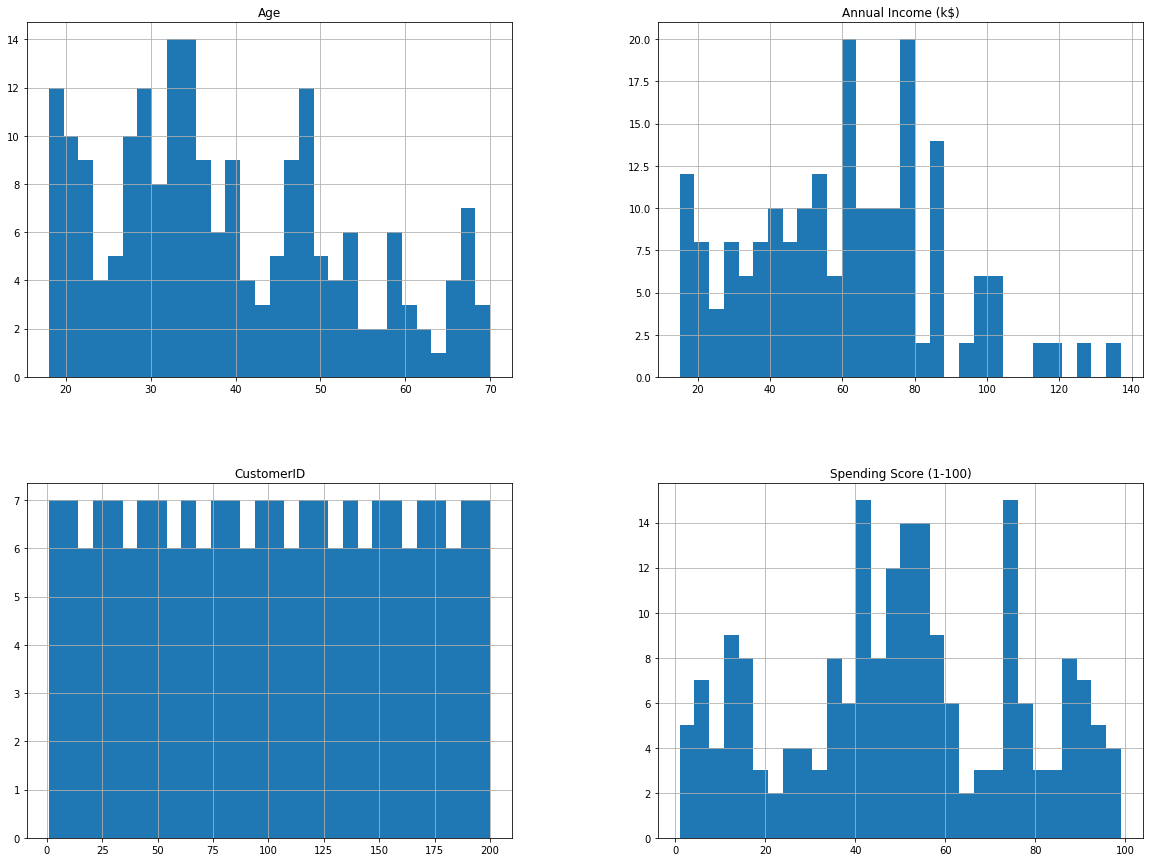

In [4]:
Customers.hist(bins=30,figsize=(20,15)) #figsize를 통해 plot 크기 조절
plt.show()

In [5]:
def encoding (x):
    if x == 'Female':
        return 0
    else:
        return 1
Customers['Gender'] = Customers['Gender'].apply(encoding) #남자는 0으로 여자는 1로 인코딩 하였습니다.

In [6]:
scaler = StandardScaler() 
Customers = scaler.fit_transform(Customers[['Gender','Age','Annual Income (k$)','Spending Score (1-100)']])
Customers = pd.DataFrame(Customers)
Customers.columns = ['Gender','Age','Annual Income (k$)','Score']
# Customers에 대해서 스케일링을 진행하였습니다. 

## 2. Clustering (수업시간에 배운 세 가지 방법 +α)

클러스터링은 중첩의 여부에 따라서 **1)계층적 군집화** 와 **2)비계층적 군집화**로 나눌 수 있습니다.

1)계층적 군집화는 계층이 묶이는 방식에 따라 **1)Agglomerative** 와 **2)Divisive**로 나눌 수 있습니다. 

단일데이터 간 거리(Euclidean, Manhattan distance 등)를 정하고 군집-군집 or 군집-개체 간 거리(Min,Max,Ward's 등)를 정의하여 돌리는 방식입니다. 

2)비계층적 군집화는 군집에 대한 가정에 따라 **1)Center-based Clustering** 과 **2)Density-based Clustering**으로 나눌 수 있습니다. 

Cneter based 에는 대표적으로 k-means가 있으며 Density-based에는 DBSCAN이 있습니다. 

### 2.1 Hierarchical Clustering

먼저 계층적 군집화를 진행하였습니다. 

In [7]:
Customers['Score'].describe()

count    2.000000e+02
mean    -1.121325e-16
std      1.002509e+00
min     -1.910021e+00
25%     -5.997931e-01
50%     -7.764312e-03
75%      8.851316e-01
max      1.894492e+00
Name: Score, dtype: float64

In [8]:
def f(x):
    if x >= 8.851316e-01:
        return 2
    elif x>=-5.997931e-01:
        return 1
    else:
        return 0
# 스케일링한 이후의 값에서 75%이상과 25%이상 그리고 나머지로 인코딩하여 VIP_3이라는 이름으로 만들어 보았습니다. 

In [9]:
Customers["VIP_3"] = Customers["Score"].apply(f)

In [10]:
def f(x):
    if x >= -7.764312e-03:
        return 1
    else:
        return 0
#같은 방식으로 상위 50%이상과 이하로 나누어 보았습니다. 

In [11]:
Customers["VIP_2"] = Customers["Score"].apply(f)

In [12]:
def f(x):
    if x >= 8.851316e-01:
        return 3
    elif x>=-7.764312e-03:
        return 2
    elif x>= -5.997931e-01:
        return 1
    else:
        return 0
# 4단계로 나누어 만들어보았습니다. 

In [13]:
Customers["VIP_4"] = Customers["Score"].apply(f)

In [14]:
labels= pd.DataFrame(Customers['VIP_2'])
labels.columns=['labels']
labels.head()

,labels
0,0
1,1
2,0
3,1
4,0


<Figure size 2880x1440 with 0 Axes>

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [60.0, 60.0, 80.0, 80.0],
  [40.0, 40.0, 70.0, 70.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [130.0, 130.0, 152.5, 152.5],
  [102.5, 102.5, 141.25, 141.25],
  [55.0, 55.0, 121.875, 121.875],
  [12.5, 12.5, 88.4375, 88.4375],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [200.0, 200.0, 222.5, 222.5],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [252.5, 252.5, 283.75, 283.75],
  [211.25, 211.25, 268.125, 268.125],
  [180.0, 180.0, 239.6875, 239.6875],
  [50.46875, 50.46875, 209.84375, 209.84375],
  [325.0, 325.0, 335.0, 335.

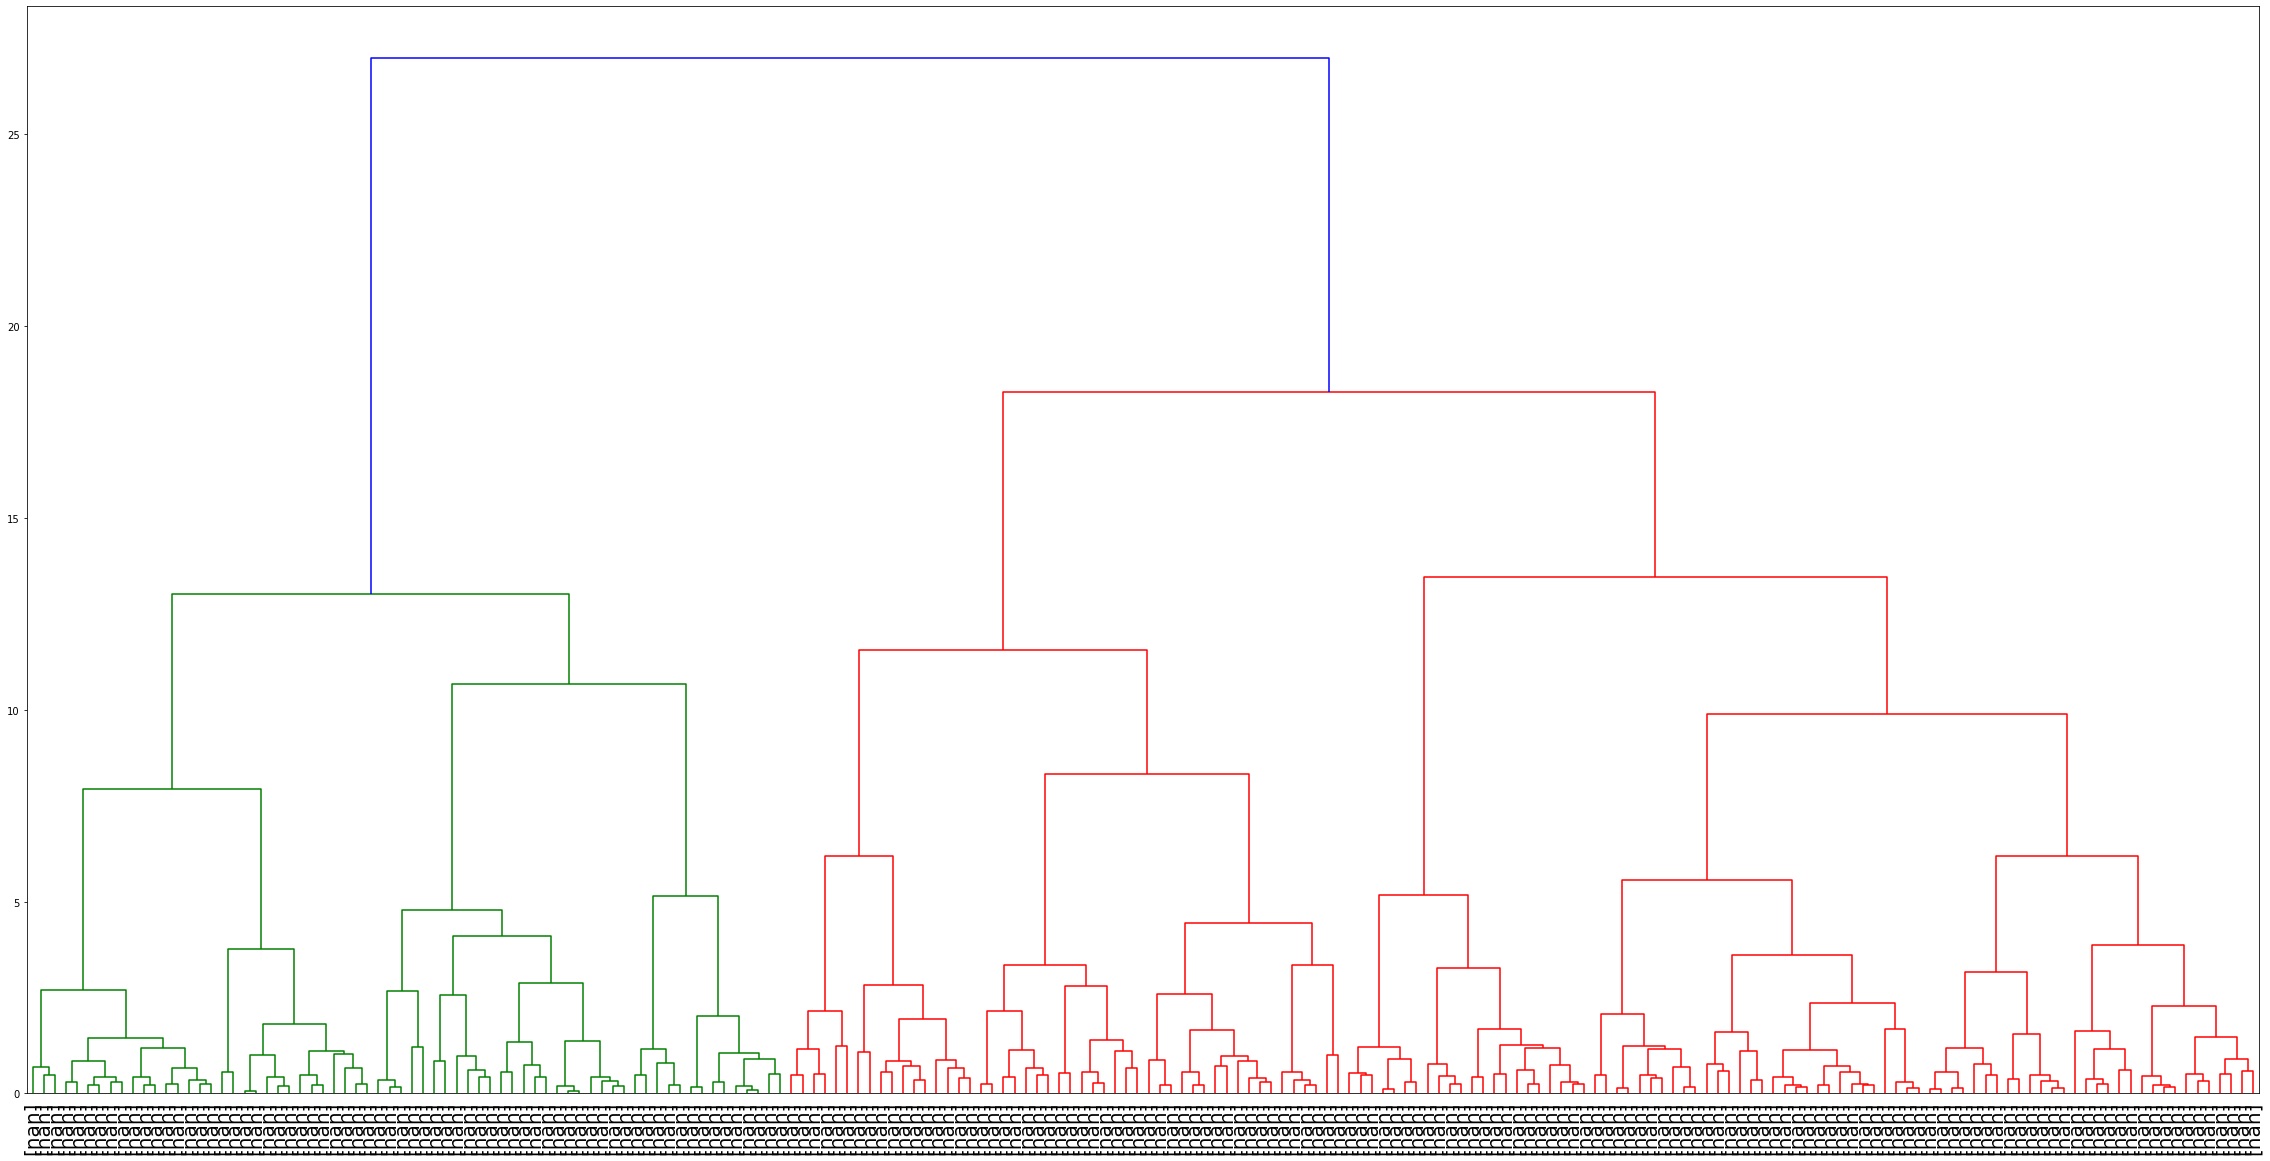

In [15]:
# Calculate the linkage: mergings
# method = 'single','complete', 'average', 'weighted', 'centroid', 'median', 'ward'
mergings_ward = linkage(Customers, method='ward')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(40,20))
dendrogram(mergings_ward,
           labels = labels.as_matrix(columns=['VIP_2']),
           leaf_rotation=90,
           leaf_font_size=20,
)
# 거리계산은 ward방식으로, 라벨은 위에서 만든 VIP_2를 이용하였습니다. 

## 2.2 Hierarchical Clustering Evaluation

클러스터링의 적당한 거리를 라벨 VIP_2처럼 2개로 나누기 위해 거리를 15로 하였습니다. 

In [16]:
from scipy.cluster.hierarchy import fcluster
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

predict = pd.DataFrame(fcluster(mergings_ward,15,criterion='distance'))
predict.columns=['predict'] # predict column에 예측 결과
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

ct = pd.crosstab(predict['predict'],labels['labels'])
ct

labels,0,1
predict,,
1,5,63
2,50,0
3,48,34


예측치에 대해서 매우 완벽하지는 않지만 어느정도? 라벨 0과 1을 구분하고 있다고 판단하였스빈다. 

### 2.3 silhouette_score

In [17]:
from sklearn.metrics import silhouette_score, silhouette_samples
silhouette_score(labels,predict, metric='euclidean')
#silhouette_score로 확인해보았을때 0.45로 높게 나오는 것을 알 수 있습니다. 

0.11093516791044773

## 3.1 K-Means Clustering

In [18]:
feature = Customers[['Gender','Age','Annual Income (k$)']]
#동일하게 feature를 만들고 k-means를 진행해 보도록 하겠습니다. 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'Elbow curve')

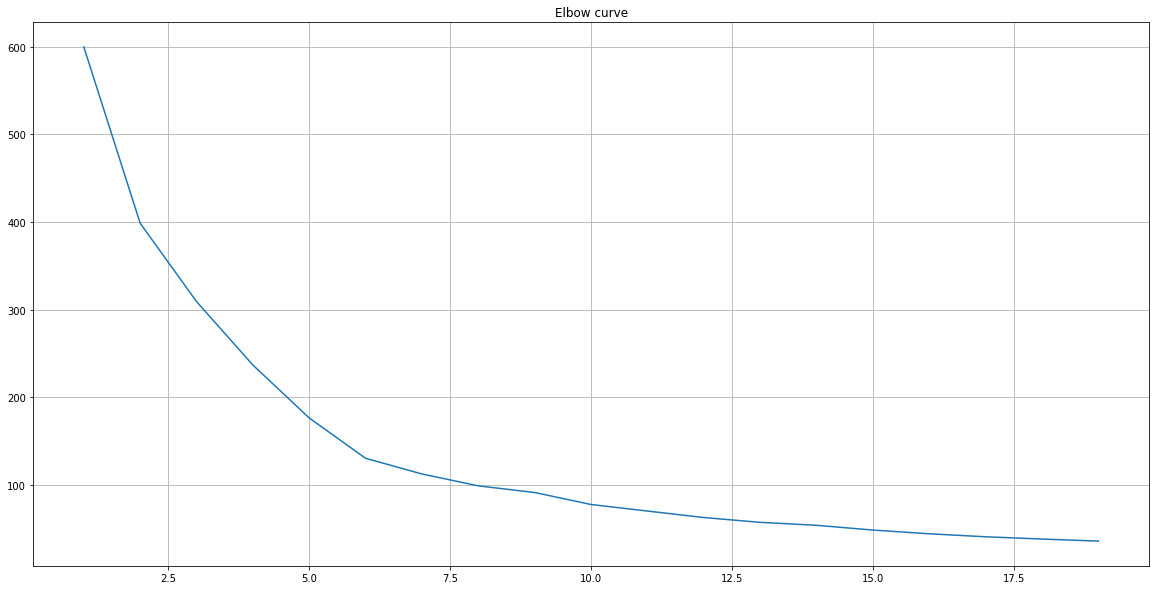

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

X = feature
distorsions = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(20, 10))
plt.plot(range(1, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')


In [20]:
#Elbow curve를 판단했을 때 2.5에서 5.0 사이와 5.0에서 7.5 사이가 두드러진 포인트라고 판단하였습니다.
#위에서 VIP_4라는 이름으로 4개의 라벨을 만들었기 때문에 여기서도 k=4로 지정하여 k-means clustering을 진행해 보도록 하겠습니다. 
model = KMeans(n_clusters=4,algorithm='auto')
model.fit(feature)

predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
r.tail()

,Gender,Age,Annual Income (k$),predict
195,-0.886405,-0.276302,2.268791,2
196,-0.886405,0.441365,2.497807,2
197,1.128152,-0.491602,2.497807,1
198,1.128152,-0.491602,2.917671,1
199,1.128152,-0.635135,2.917671,1


Text(0.5, 0, 'Gender')

Text(0.5, 0, 'Age')

Text(0.5, 0, 'Annual Income (k$)')

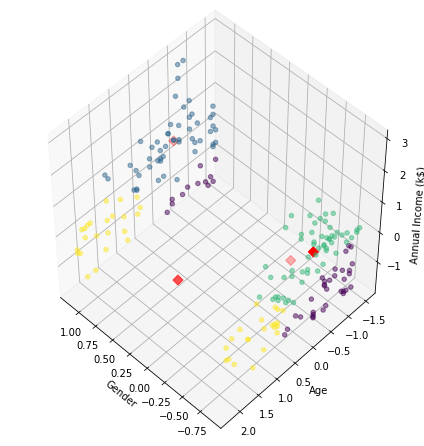

In [22]:
centers = pd.DataFrame(model.cluster_centers_,columns=['Gender','Age','Annual Income (k$)'])
center_x = centers['Gender']
center_y = centers['Age']
center_z = centers['Annual Income (k$)']

from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Age'],r['Annual Income (k$)'],c=r['predict'],alpha=0.5)
ax.scatter(center_x,center_y,center_z,s=50,marker='D',c='r')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
ax.set_zlabel('Annual Income (k$)')
plt.show()
#다음과 같이 그래프가 그려짐을 확인할 수 있었습니다. 특히 age와 income에 따라서 잘 나눠진다고 판단하였습니다. 

## 3.2 K-Means Evaluation
https://bcho.tistory.com/1203

In [23]:
Customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
Gender                200 non-null float64
Age                   200 non-null float64
Annual Income (k$)    200 non-null float64
Score                 200 non-null float64
VIP_3                 200 non-null int64
VIP_2                 200 non-null int64
VIP_4                 200 non-null int64
dtypes: float64(4), int64(3)
memory usage: 11.1 KB


In [24]:
ct = pd.crosstab(Customers['VIP_4'],r['predict'])
print (ct)
print (model.inertia_)

#예측값과 분류에 대해서는 크게 유의미하지는 않게 나타남을 알 수 있었습니다. 
#inertia_값은 237로 scaling이전보다 크게 감소한 것을 확인하였습니다. 

predict   0   1   2   3
VIP_4                  
0         8  17  14  11
1         8   8  17  20
2        14  14  10  14
3        14  14  17   0
238.09023146702887


In [25]:
from sklearn.metrics import silhouette_score, silhouette_samples
silhouette_score(labels,r['predict'], metric='euclidean')
#silhouette_score 점수도 음수로 크게 유의미하다고 볼 수 없을 것 같습니다. 

-0.18184918569709768

## 4.1 DBSCAN

마지막으로 DBSCAN을 통해서 클러스터링을 해보도록 하겠습니다. 

In [26]:
#먼저 k-dist를 확인하여 적당한 eps를 확인해보록 하겠습니다. 
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(feature)
distances, indices = nbrs.kneighbors(feature)

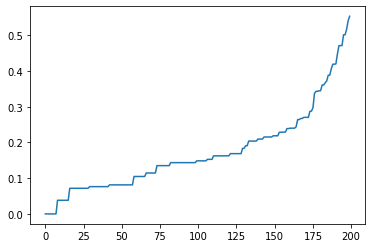

In [27]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#0.35가 적당하다고 판단하였습니다. 

In [28]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# create model and prediction
model = DBSCAN(eps=2,min_samples=4)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

Text(0.5, 0, 'Gender')

Text(0.5, 0, 'Age')

Text(0.5, 0, 'Annual Income (k$)')

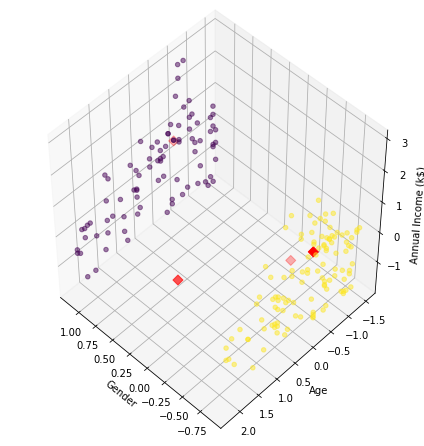

In [29]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Gender'],r['Age'],r['Annual Income (k$)'],c=r['predict'],alpha=0.5)
ax.scatter(center_x,center_y,center_z,s=50,marker='D',c='r')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
ax.set_zlabel('Annual Income (k$)')
plt.show()

### 4.2 DBSCAN Evaluation

In [30]:
ct = pd.crosstab(Customers['VIP_2'],r['predict'])
print (ct)
#평가결과는 그렇게 좋지 못한듯여....

predict   0   1
VIP_2          
0        44  59
1        44  53


In [31]:
from sklearn.metrics import silhouette_score, silhouette_samples
silhouette_score(labels,r['predict'], metric='euclidean')
#silhouette_score역시 높지않은 것으로 나타났습니다. 

-0.007797551585358475

# 5 MeanShift¶

In [93]:
from sklearn.cluster import MeanShift
import numpy as np
X = feature
clustering = MeanShift(bandwidth=2).fit(X)
clustering.fit_predict(X)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1], dtype=int64)

In [92]:
predict = pd.DataFrame(clustering.fit_predict(X))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

In [96]:
ct = pd.crosstab(Customers['VIP_2'],r['predict'])
print (ct)

predict   0   1
VIP_2          
0        59  44
1        53  44
